In [1]:
!pip install nltk
!pip install transformers
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
df = pd.read_csv('Reviews.csv')
df = df.head(500) #Only taking first 500 rows for analysis since there are >500,000 reviews

## Quick EDA

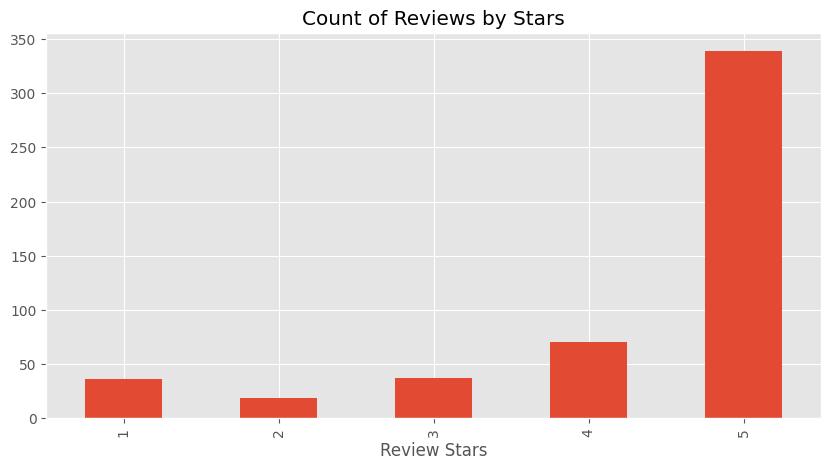

In [3]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [4]:
#Takes 50th element of dataframe and tokenizes it (interpretable by the computer)
example = df['Text'][50]
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [5]:
#Gives tag to each part of speech
tagged = nltk.pos_tag(tokens)
tagged[:10]
#Link to meanings of NLTK pos_tags : https://gist.github.com/amnrzv/9a701f419ad004e066e2d6007dae40ad

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [6]:
#Takes tokens and groups them into chunks of texts
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## 1. VADER Sentiment Scoring

#### Uses NLTK's Sentiment IntensityAnalyzer to get neg/neu/pos scores of text

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [8]:
sia = SentimentIntensityAnalyzer()
example2 = "I am so happy!"
print(f"Polarity Scores for '{example2}': {sia.polarity_scores(example2)}")
print(f"Polarity Scores for '{example[:13]}...': {sia.polarity_scores(example)}")
#Compound values go from -1 to +1 

Polarity Scores for 'I am so happy!': {'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}
Polarity Scores for 'This oatmeal ...': {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


In [9]:
#Polarity scores on entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left') #merge sentiments to original dataset
vaders.head()

  0%|          | 0/500 [00:00<?, ?it/s]

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


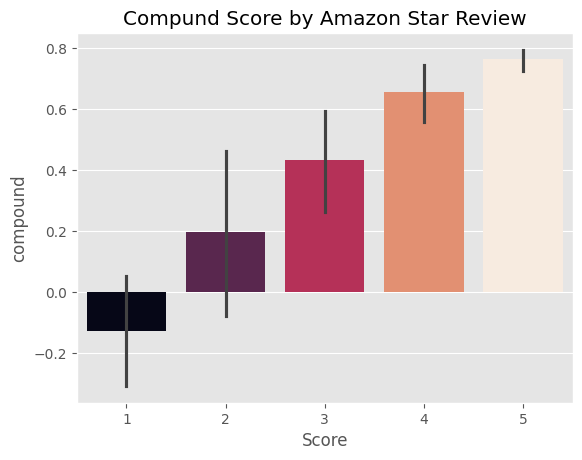

In [10]:
#Comparing Star Reviews to Polarity Scores
ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score', palette = 'rocket')
ax.set_title('Compund Score by Amazon Star Review')
ax.legend_.remove()
plt.show()

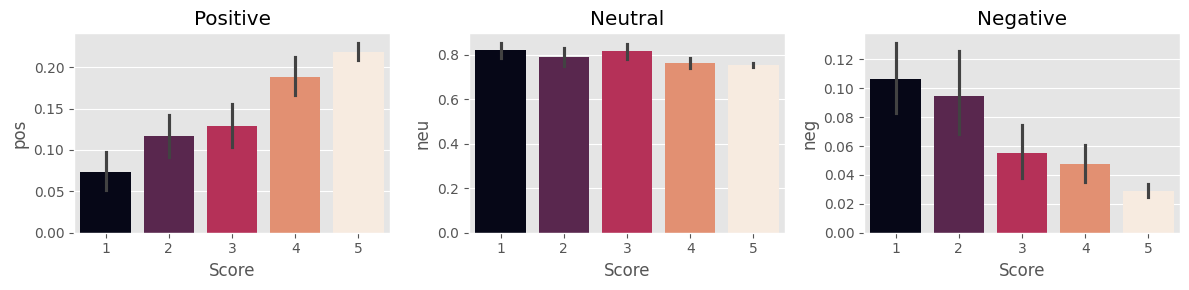

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0], hue='Score', palette = 'rocket')
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1], hue='Score', palette = 'rocket')
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2], hue='Score', palette = 'rocket')
axs[0].set_title('Positive'); axs[0].legend_.remove()
axs[1].set_title('Neutral'); axs[1].legend_.remove()
axs[2].set_title('Negative'); axs[2].legend_.remove()
plt.tight_layout()
plt.show()

### Observations
- Positive sentiment scores increase as Review score(stars) increase
- Negative sentiment scores decrease as Review score(stars) increase
- Neutral sentiment scores are relatively uncorrelated with Review score(stars)
- Overall, VADER sentiment scores does well in relating Review comments to Review score(stars)

## 2. Roberta Pretained Model

#### Transformer model accounts for the words but also the context related to other words

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [13]:
#Get pretrained model weights based on twitter comments sentiment analysis by HuggingFace
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [14]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text) #attach model to encoded_text
    scores = output[0][0].detach().numpy() #stored as tensor, so detaching and storing as numpy
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [15]:
polarity_scores_roberta(example)
print(f"Polarity Scores for example using Roberta: {polarity_scores_roberta(example)}")
print(f"Polarity Scores for example using VADER: {sia.polarity_scores(example)}")

Polarity Scores for example using Roberta: {'roberta_neg': 0.97635514, 'roberta_neu': 0.020687485, 'roberta_pos': 0.0029573736}
Polarity Scores for example using VADER: {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


In [16]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index': 'Id'})
final = roberta.merge(vaders, how='left')
final.head()

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


,Id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907485,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


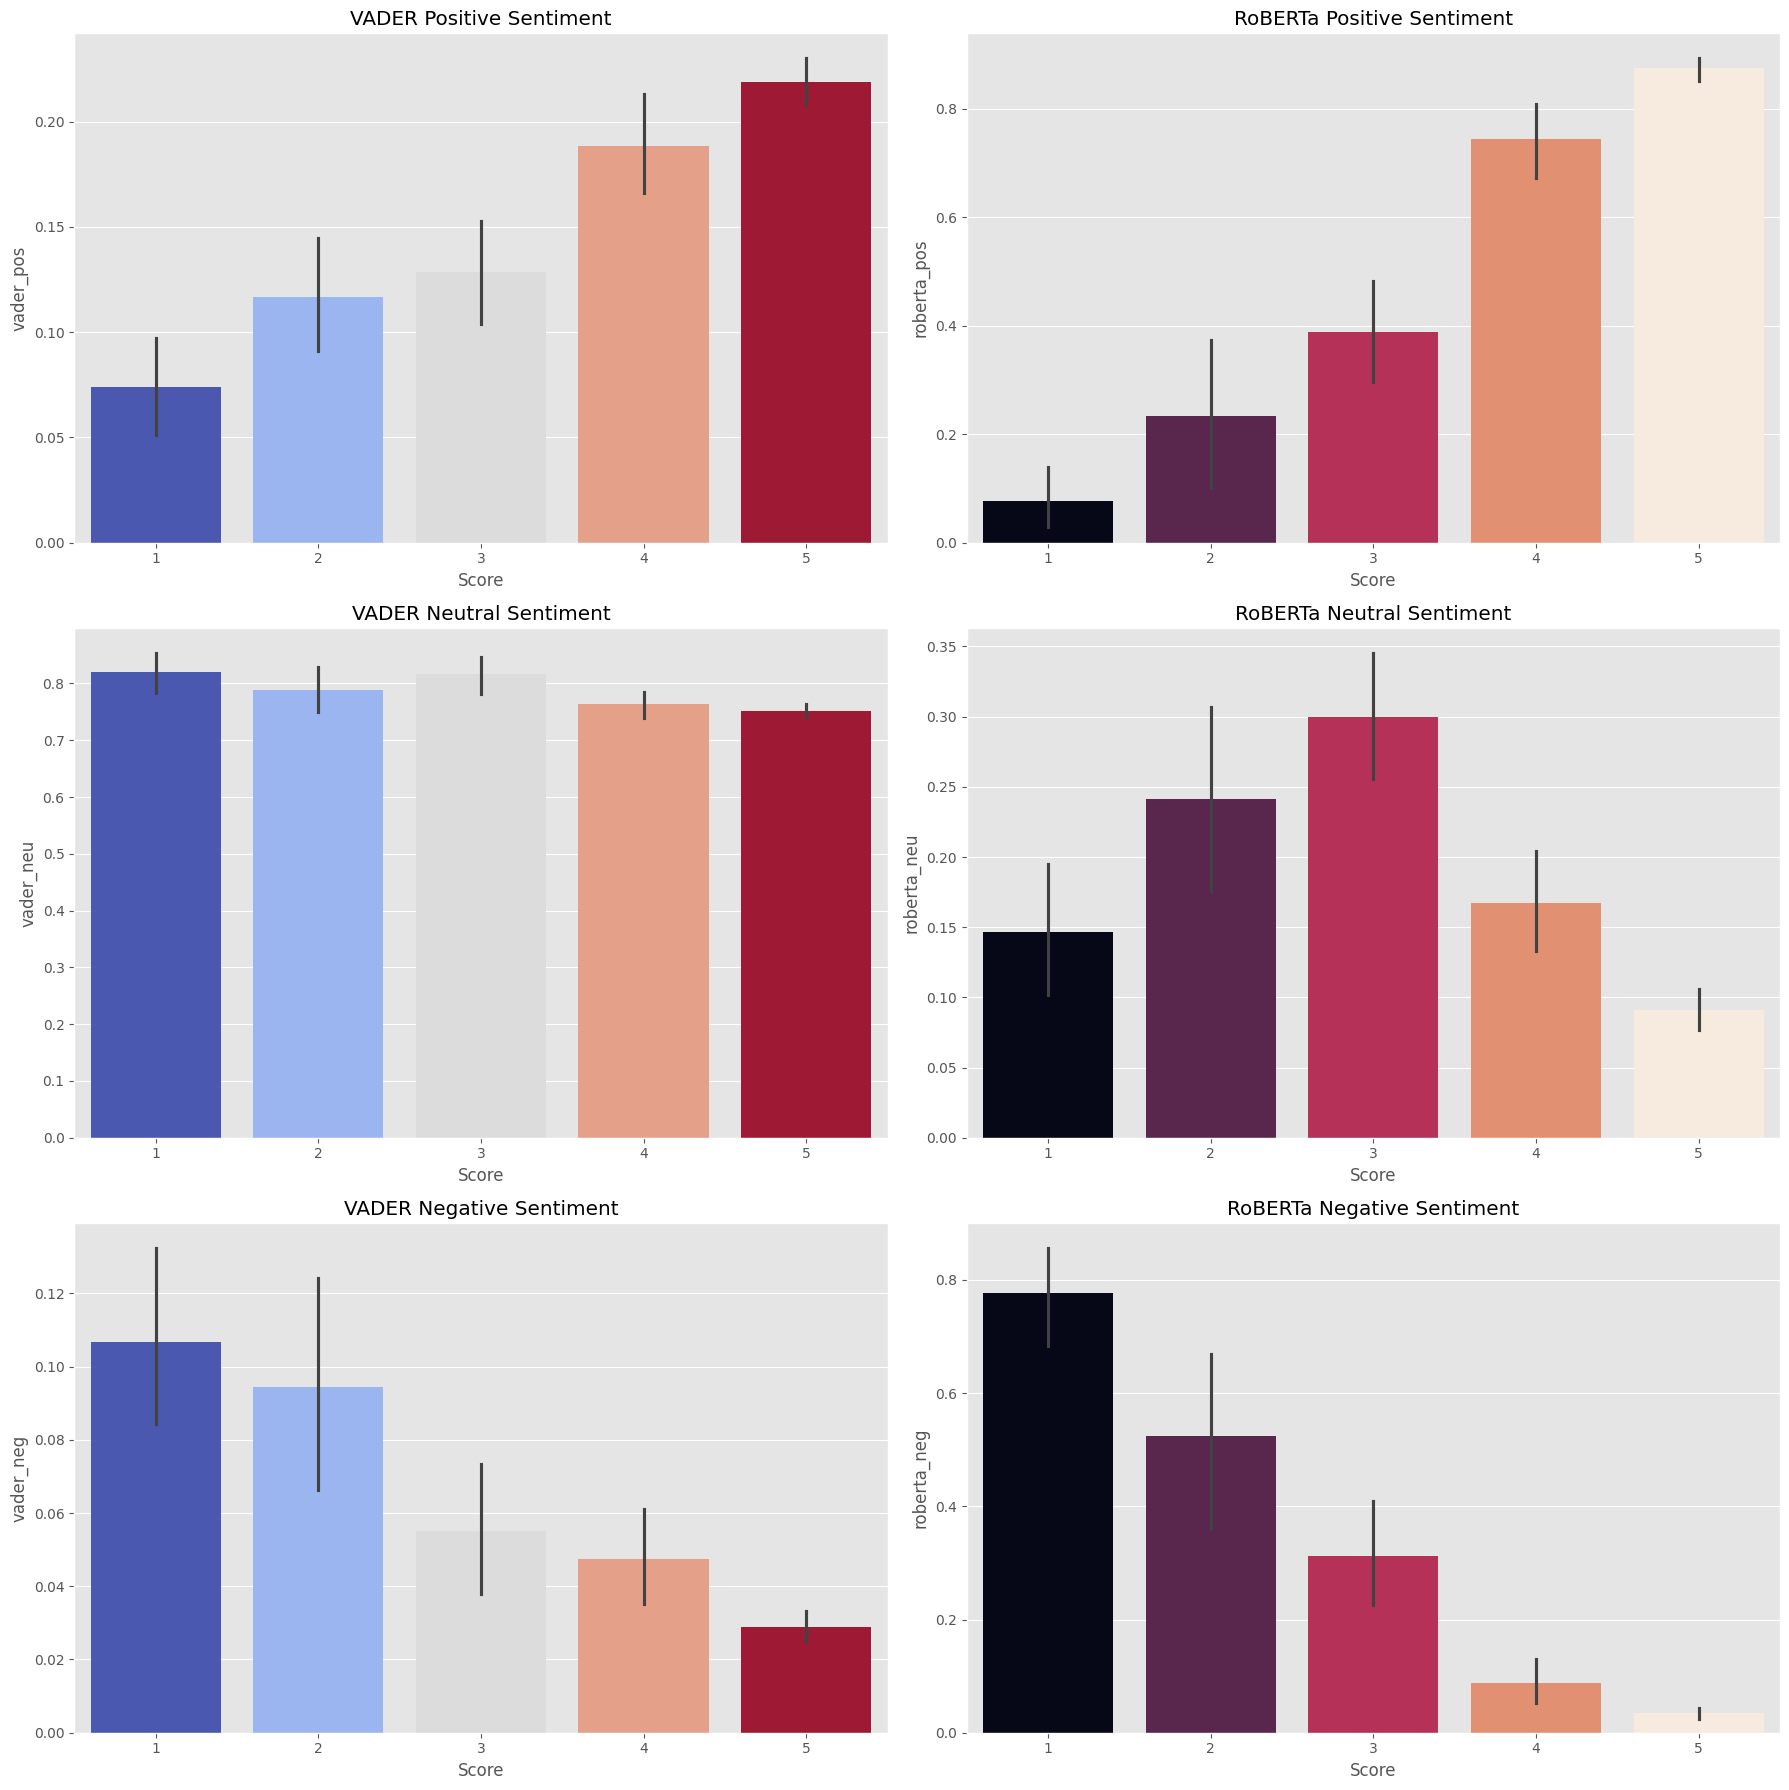

In [25]:
final = final.rename(
    columns={'neg': 'vader_neg','neu': 'vader_neu','pos': 'vader_pos', 'compound': 'vader_compound'})

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# Positive Sentiment Comparison
sns.barplot(data=final, x='Score', y='vader_pos', ax=axs[0, 0], hue='Score', palette='coolwarm', legend = False)
sns.barplot(data=final, x='Score', y='roberta_pos', ax=axs[0, 1], hue='Score', palette='rocket', legend = False)
axs[0, 0].set_title('VADER Positive Sentiment')
axs[0, 1].set_title('RoBERTa Positive Sentiment')

# Neutral Sentiment Comparison
sns.barplot(data=final, x='Score', y='vader_neu', ax=axs[1, 0], hue='Score', palette='coolwarm', legend = False)
sns.barplot(data=final, x='Score', y='roberta_neu', ax=axs[1, 1], hue='Score', palette='rocket', legend = False)
axs[1, 0].set_title('VADER Neutral Sentiment')
axs[1, 1].set_title('RoBERTa Neutral Sentiment')

# Negative Sentiment Comparison
sns.barplot(data=final, x='Score', y='vader_neg', ax=axs[2, 0], hue='Score', palette='coolwarm', legend = False)
sns.barplot(data=final, x='Score', y='roberta_neg', ax=axs[2, 1], hue='Score', palette='rocket', legend = False)
axs[2, 0].set_title('VADER Negative Sentiment')
axs[2, 1].set_title('RoBERTa Negative Sentiment')

plt.tight_layout()
plt.show()

### Observations
- Both VADER and RoBERTa show an increasing trend in positive sentiment scores with higher review scores (from 1 to 5 stars). 
The positive sentiment scores given by RoBERTa are generally higher than those given by VADER.
This could be because RoBERTa, being a more complex and context-aware model, might capture more nuances and positive expressions in the reviews compared to VADER.

- While both models show neutral sentiment scores, VADER tends to classify a larger portion of the text as neutral consistently across all review scores. RoBERTa, however, shows more variability and context-awareness, leading to a decrease in neutral sentiment as review scores become more positive or negative.

- Overall, while both models show an expected decrease in negative sentiment with higher review scores, RoBERTa tends to assign higher negative sentiment scores and shows greater variability, likely due to its more sophisticated architecture and training on diverse datasets.

## Review Examples
- Positive 1 star and negative 5 star

In [32]:
final.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [33]:
final.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [34]:
final.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [35]:
final.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Alternate : The Transformers Pipeline

In [36]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [38]:
print(f"Scores using pipeline: {sent_pipeline('yaay')}")
print(f"Scores using pipeline: {sent_pipeline('booo')}")

Scores using pipeline: [{'label': 'POSITIVE', 'score': 0.9351863861083984}]
Scores using pipeline: [{'label': 'NEGATIVE', 'score': 0.9936267137527466}]
